In [43]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from google.colab import drive
drive.mount('/content/drive')

DATA_PATH = "/content/drive/MyDrive/data/"

SEED = 42 # 시드값

# 데이터 블러오기
train = pd.read_csv(f"{DATA_PATH}titanic_train.csv") # 학습데이터
test = pd.read_csv(f"{DATA_PATH}titanic_test.csv") # 테스트 데이터

# 결측치 처리
age_mean = train["age"].mean()
fare_median = train["fare"].median()
cabin_unk = "UNK"
embarked_mode = train["embarked"].mode()[0]
train["age"] = train["age"].fillna(age_mean)
train["cabin"] = train["cabin"].fillna(cabin_unk)
test["age"] = test["age"].fillna(age_mean)
test["fare"] = test["fare"].fillna(fare_median)
test["cabin"] = test["cabin"].fillna(cabin_unk)
test["embarked"] = test["embarked"].fillna(embarked_mode)

# 특성으로 사용할 변수 선택
cols = ["age","sibsp","parch","fare","pclass","gender","embarked"]
train_ft = train[cols].copy()
test_ft = test[cols].copy()

# 범주형 변수 원핫인코딩
cols = ['gender','embarked']
enc = OneHotEncoder(handle_unknown = 'ignore')
enc.fit(train[cols])
tmp = pd.DataFrame(
    enc.transform(train_ft[cols]).toarray(),
    columns = enc.get_feature_names_out()
)
train_ft = pd.concat([train_ft,tmp],axis=1).drop(columns=cols)
tmp = pd.DataFrame(
    enc.transform(test_ft[cols]).toarray(),
    columns = enc.get_feature_names_out()
)
test_ft = pd.concat([test_ft,tmp],axis=1).drop(columns=cols)

# 정답 데이터
target = train["survived"]

train_ft.shape, test_ft.shape, target.shape

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


((916, 10), (393, 10), (916,))

# XAI(Explainable AI)
- 설명가능한 AI
- 머신러닝 모델의 예측한 결과를 사람이 이해할 수 있도록
해석을 제공하는 방법론



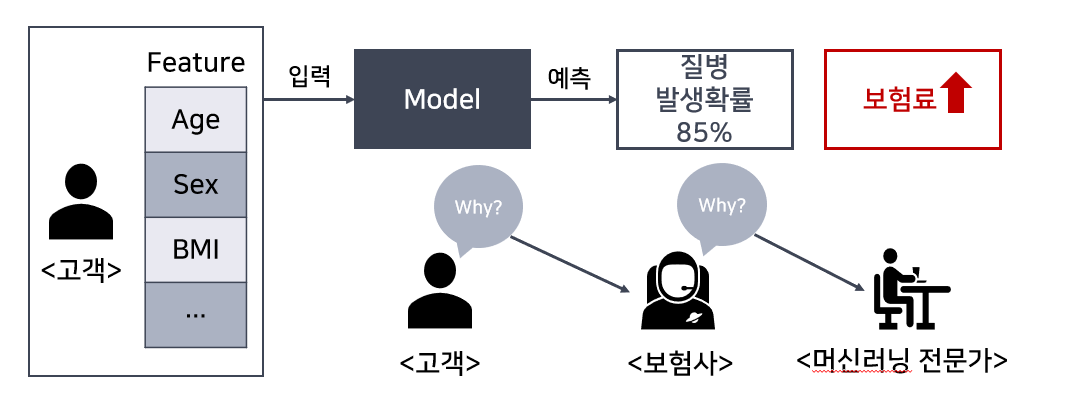

# 모델의 성능과 설명 가능성
- 모델의 복잡성과 해석력은 Trade-off 관계가 있음


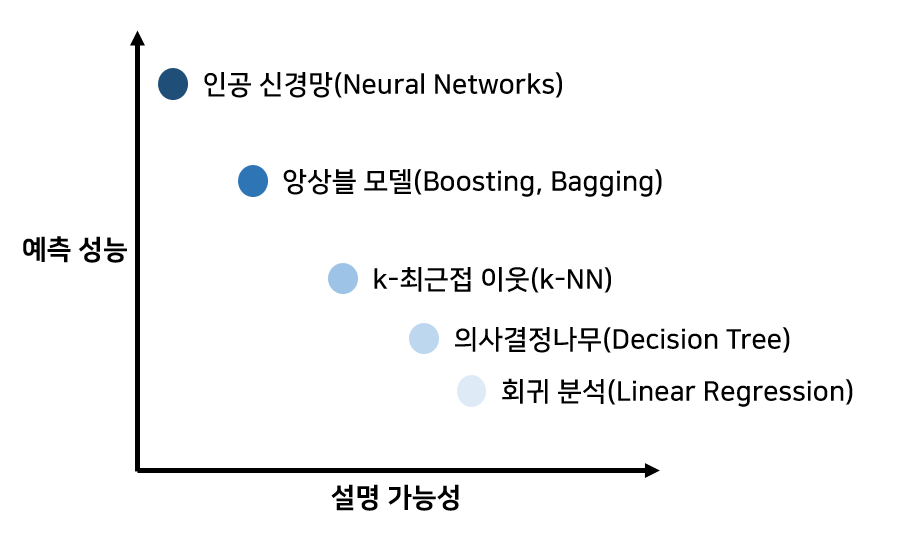

# SHAP(Shapley Additive exPlanations)​
- SHAP의 목적은 예측에 대한 각 속성(feature)의 기여도를 계산하여 관측치 x의 예측 값을 설명하는 것​을 말함
- Shapley Value를 기반으로 예측 값에 대해 각 피처가 미치는 기여도를 측정하여 예측에 대한 해석을 제공​
- https://shap.readthedocs.io/en/latest/
- 설치방법
```bash
pip install shap
```

## Shapley Value​
- Lloyd Shapley가 발표한 이론
- 게임 이론을 바탕으로 각 피처의 기여도를 계산하는 방법
- 게임 이론
    - 개인 또는 기업이 어떠한 행위를 했을 때, 그 결과가 게임에서와 같이 자신뿐만 아니라 다른 참가자의 행동에 의해서도 결정되는 상황에서, 자신의 최대 이익에 부합하는 행동을 추구한다는 수학적 이론
- 계산하고자 하는 피처를 사용했을 때의 예측 값과 사용 안 했을 때의 예측 값의 변화를 이용하여 구함


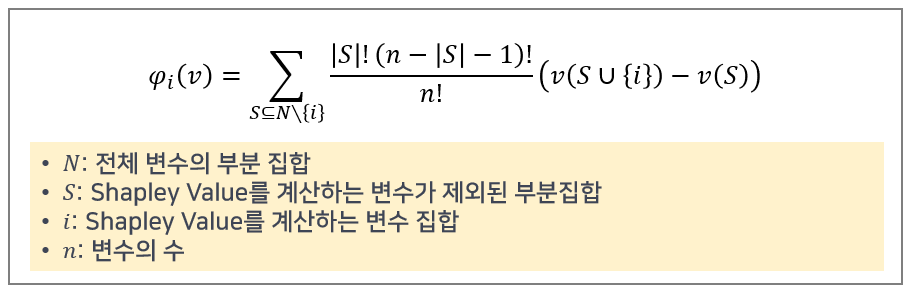

- Shapley Value는 Shapley Value를 계산하는 변수가 포함된 가능한 모든 부분집합의 각 예측 값에서 Shapley Value를 계산하는 변수를 제외했을 때에 예측 값의 변화량을 가중 평균한 값
- 모델의 예측값을 높이거나 낮추는데 얼마나 영향을 주었는지에 대해 계산된 값

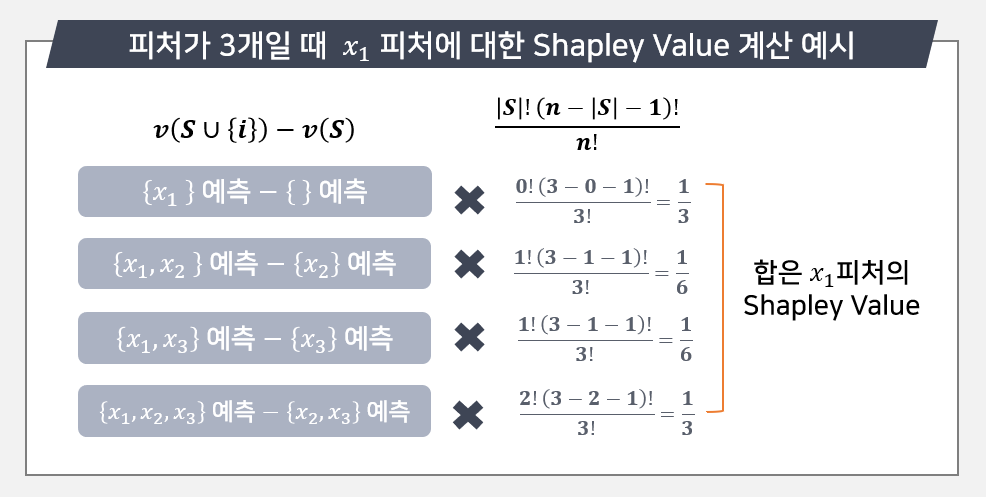

## Shapley Value 해석하기


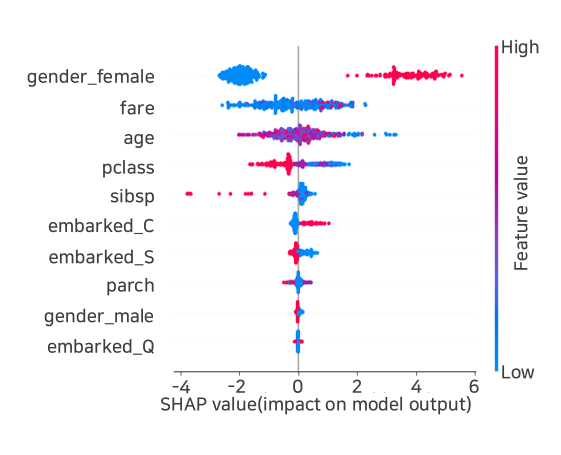

## SHAP 장점
- 각 관측치에 대한 Local Explanation 뿐만 아니라 각 피처별로 Global Explanation도 얻을 수 있음
- 전반적인 변수 중요도 산출 가능

## SHAP 단점
- Shapley Value 계산 시 수많은 경우에 대한 연산이 이루어지므로 많은 수행시간이 필요
- Shapley Value를 해석할 때 원인과 결과의 관계로 해석하면 안됨

In [44]:
train_ft = train_ft.drop(columns="gender_female")
test_ft = test_ft.drop(columns="gender_female")

train_ft.shape, test_ft.shape

((916, 9), (393, 9))

In [45]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import KFold, cross_val_score

cv = KFold(5, shuffle=True, random_state=SEED)
model = LGBMClassifier(random_state=SEED)
cross_val_score(model, train_ft, target, cv=cv, scoring="roc_auc", n_jobs=-1).mean()

0.8957078739771841

In [46]:
model.fit(train_ft, target)

[LightGBM] [Info] Number of positive: 346, number of negative: 570
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000204 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 237
[LightGBM] [Info] Number of data points in the train set: 916, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.377729 -> initscore=-0.499198
[LightGBM] [Info] Start training from score -0.499198


LGBMClassifier(random_state=42)

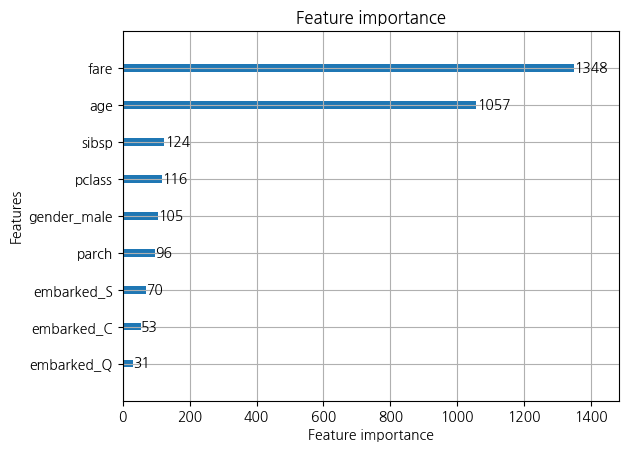

In [47]:
from lightgbm import plot_importance
import matplotlib.pyplot as plt

plot_importance(model) # 어떤 피처의 중요도가 높은지만 알 수 있음
plt.show()

In [48]:
import shap

explainer = shap.TreeExplainer(model) # 학습 완료된 모델객체를 전달하여 shapley value 를 계산할 수 있는 객체 생성
shap_values = explainer.shap_values(test_ft)
shap_values

/usr/local/lib/python3.10/dist-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


array([[-9.14171001e-01,  6.25408843e-02,  7.85386232e-02, ...,
         6.53325689e-02,  4.40580809e-04,  3.26282406e-02],
       [-2.66994452e-01,  4.25767277e-02,  8.25675047e-02, ...,
         9.61609294e-03,  1.23202550e-03, -5.55479528e-02],
       [-1.61696130e+00,  3.10051819e-02, -3.94613519e-02, ...,
        -1.09535187e-01,  7.72488585e-03, -8.95190618e-02],
       ...,
       [-1.30032441e+00, -9.31231632e-03, -3.10154799e-02, ...,
        -1.16827022e-01,  1.03672008e-02, -1.22129725e-01],
       [ 2.83382469e-01,  2.39067273e-02,  2.40431291e-03, ...,
        -1.67260651e-01,  8.14829377e-04, -4.95608390e-02],
       [ 8.16737494e-01,  1.59487992e-01,  8.27907892e-03, ...,
        -1.48272624e-01,  1.02028736e-02, -1.39905565e-01]])

## 하나의 샘플의 예측결과 해석해보기

- force_plot 함수
    - 첫 번째 인수로 expected_value 전달
    - 두 번째 인수로 shap_values 전달
    - 세 번째 인수로 features 전달
    - link 파라미터
        - 'identity': 예측값을 실수로 표시
        - 'logit': 예측값을 확률 표시

In [49]:
expected_value = explainer.expected_value # 예측에 대한 기대값
expected_value

-0.8400639482024891

In [50]:
n = 3
shap.initjs()
shap.force_plot(expected_value, shap_values[n], test_ft.iloc[n], link="logit")

## 전체 예측 결과에 대해 피처별로 예측에 대한 영향을 해석해보기

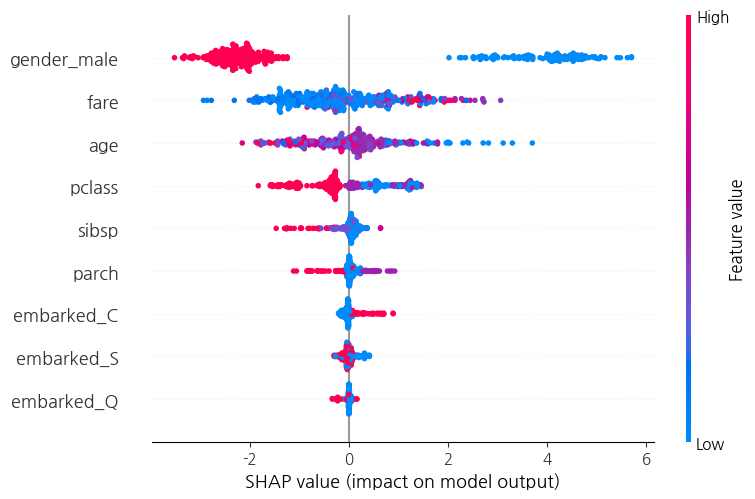

In [51]:
shap.summary_plot(shap_values, test_ft)

- dependence_plot 함수
    - 각 피처의 shap value 의 산점도와 높은 상호작용하는 피처를 분석 가능
    - 주요 파라미터
        - 첫 번째 인수로 컬럼명 전달
        - 두 번째 인수로 shape_values 전달
        - 세 번째 인수로 features 전달
        - interaction_index 파라미터
            - 'auto': 높은 상호작용하는 피처를 자동으로 세팅
            - 피처명을 전달할 경우 해당 피처를 같이 그래프에 표시
            - None 을 전달할 경우 상호작용하는 피처를 표시하지 않음

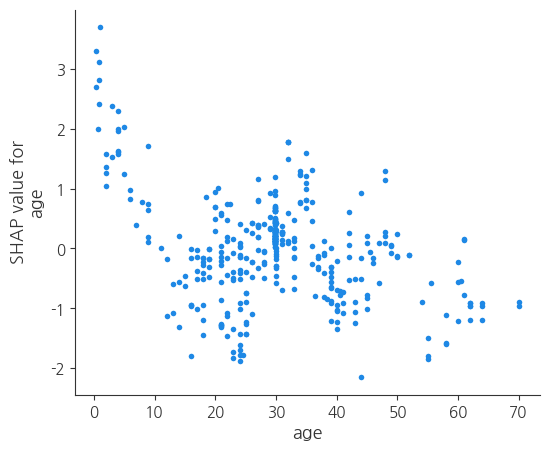

In [52]:
shap.dependence_plot("age", shap_values, test_ft, interaction_index=None)

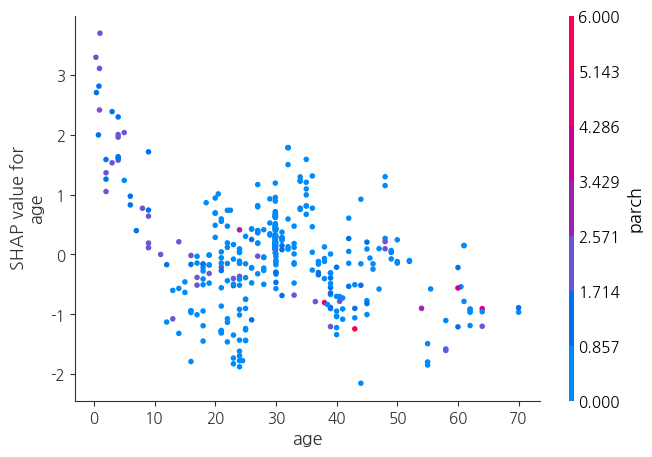

In [53]:
shap.dependence_plot("age", shap_values, test_ft, interaction_index='auto')

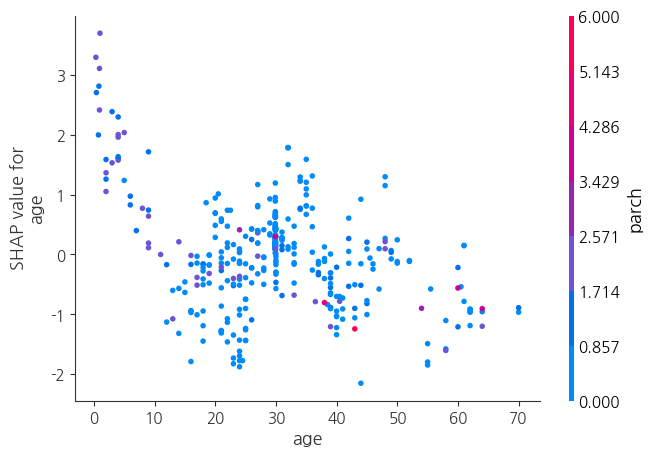

In [54]:
shap.dependence_plot("age", shap_values, test_ft, interaction_index='parch')

- 반복문 돌려서 모든 피처 산점도 그려보기

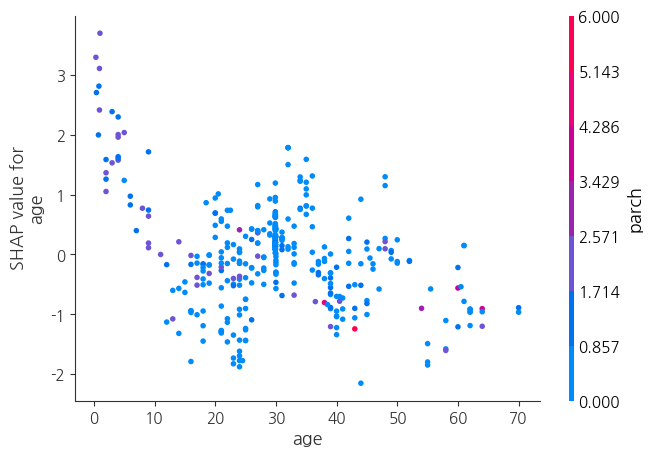

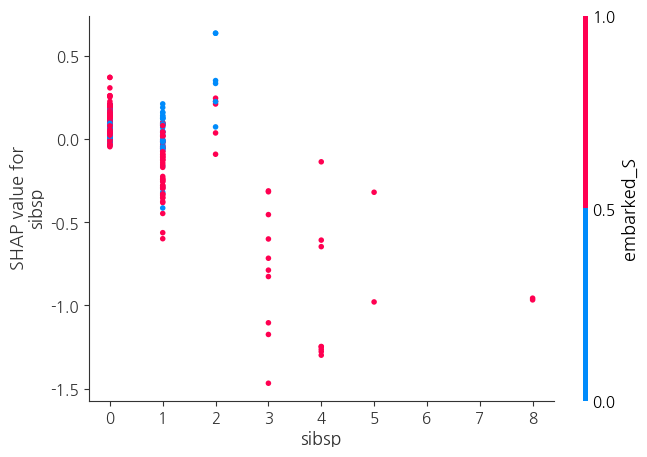

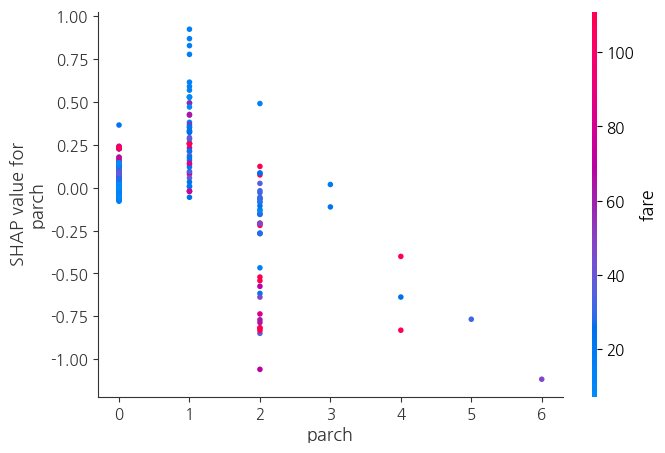

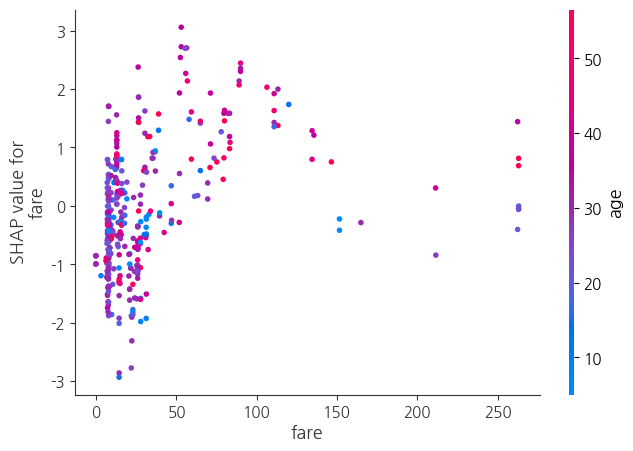

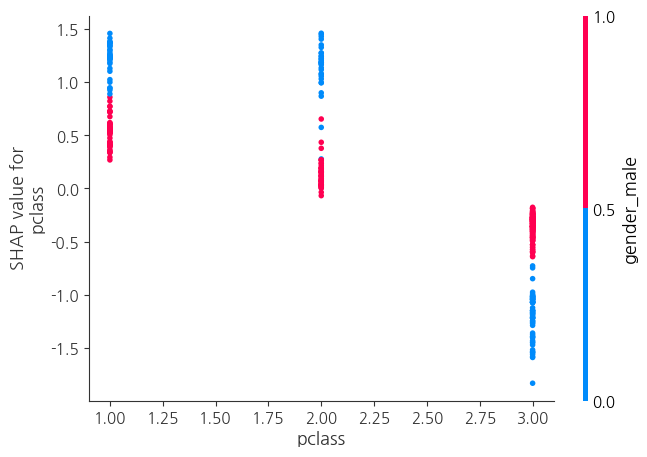

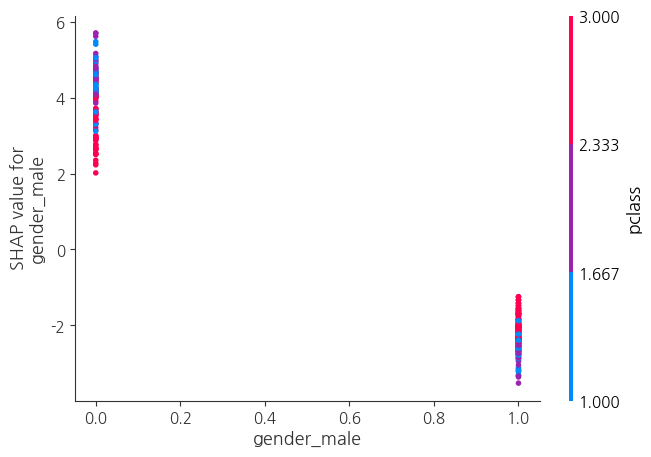

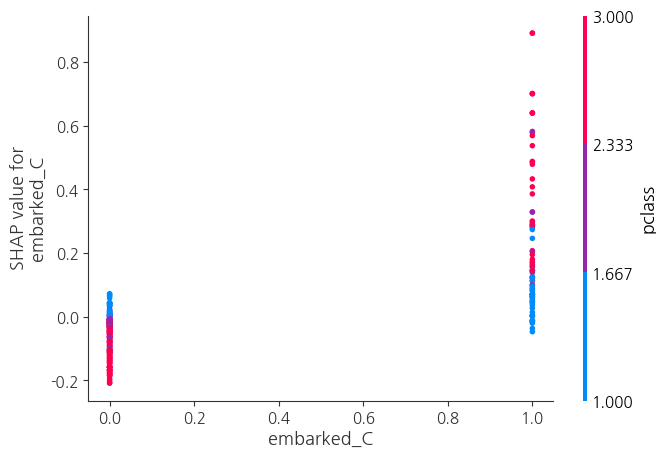

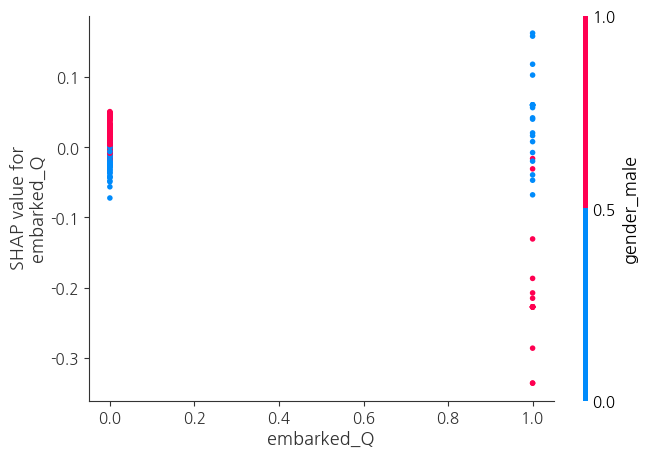

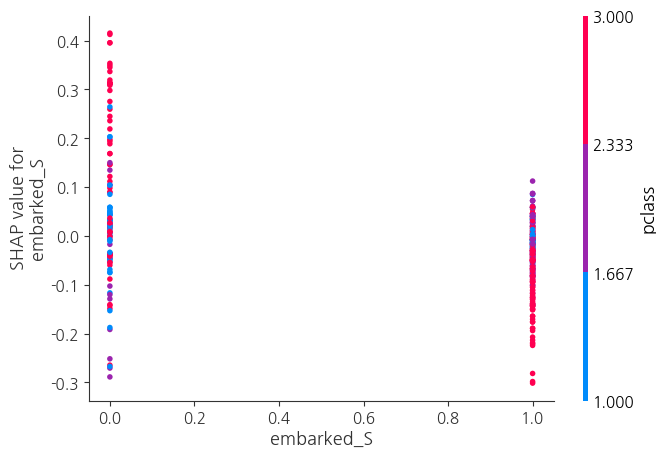

In [55]:
for col in test_ft.columns:
    shap.dependence_plot(col, shap_values, test_ft)
    print()

# 다중분류

In [56]:
import matplotlib
from matplotlib import font_manager

!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv

fontpaths = ["/usr/share/fonts/truetype/nanum/"]
font_files = font_manager.findSystemFonts(fontpaths=fontpaths)

for ff in font_files:
    font_manager.fontManager.addfont(ff)

matplotlib.rc('font', family="NanumGothic")
matplotlib.rcParams['axes.unicode_minus'] = False

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

In [57]:
from sklearn.preprocessing import OneHotEncoder

train = pd.read_csv(f"{DATA_PATH}loan_grade_train.csv")
test = pd.read_csv(f"{DATA_PATH}loan_grade_test.csv")

period_mean, interest_mean = train["근로기간"].mean(), train["이자율"].mean()

train["근로기간"] = train["근로기간"].fillna(period_mean)
train["이자율"] = train["이자율"].fillna(interest_mean)

test["근로기간"] = test["근로기간"].fillna(period_mean)
test["이자율"] = test["이자율"].fillna(interest_mean)

train_ft = train.iloc[:,1:-1].copy()
test_ft = test.iloc[:,1:].copy()

cols = ["주택소유상태", "대출목적"]
enc = OneHotEncoder(handle_unknown="ignore")
enc.fit(train_ft[cols])
train_ft[enc.get_feature_names_out()] = enc.transform(train_ft[cols]).toarray()
test_ft[enc.get_feature_names_out()] = enc.transform(test_ft[cols]).toarray()
train_ft = train_ft.drop(columns=cols)
test_ft = test_ft.drop(columns=cols)

target = train["target"]

In [58]:
train_ft.isna().sum().sum(), test_ft.isna().sum().sum()

(0, 0)

In [59]:
from lightgbm import LGBMClassifier

model = LGBMClassifier(random_state=SEED)
model.fit(train_ft, target)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000498 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 843
[LightGBM] [Info] Number of data points in the train set: 19548, number of used features: 16
[LightGBM] [Info] Start training from score -1.106315
[LightGBM] [Info] Start training from score -1.137097
[LightGBM] [Info] Start training from score -1.618327
[LightGBM] [Info] Start training from score -2.195385
[LightGBM] [Info] Start training from score -3.521054
[LightGBM] [Info] Start training from score -4.903895
[LightGBM] [Info] Start training from score -6.243042


LGBMClassifier(random_state=42)

In [70]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(test_ft)
shap_values.shape, shap_values[:,:,0].shape

((13033, 16, 7), (13033, 16))

In [64]:
expected_value = explainer.expected_value
expected_value

[28.46711424336827,
 -55.26397098427568,
 -23.555247079711627,
 -16.85113052187542,
 -24.8758933280682,
 -118.92072585737704,
 -6642.714285089227]

In [65]:
pred = model.predict(test_ft)
pred

array([1, 1, 1, ..., 0, 0, 0])

In [66]:
n = 0
c = pred[n]
print(c, "클래스")
shap.initjs()
shap.force_plot(expected_value[c], shap_values[n,:,c], test_ft.iloc[n], link="logit")

1 클래스


- 클래스별로 해석

In [67]:
shap_values.shape

(13033, 16, 7)

0 클래스 summary_plot


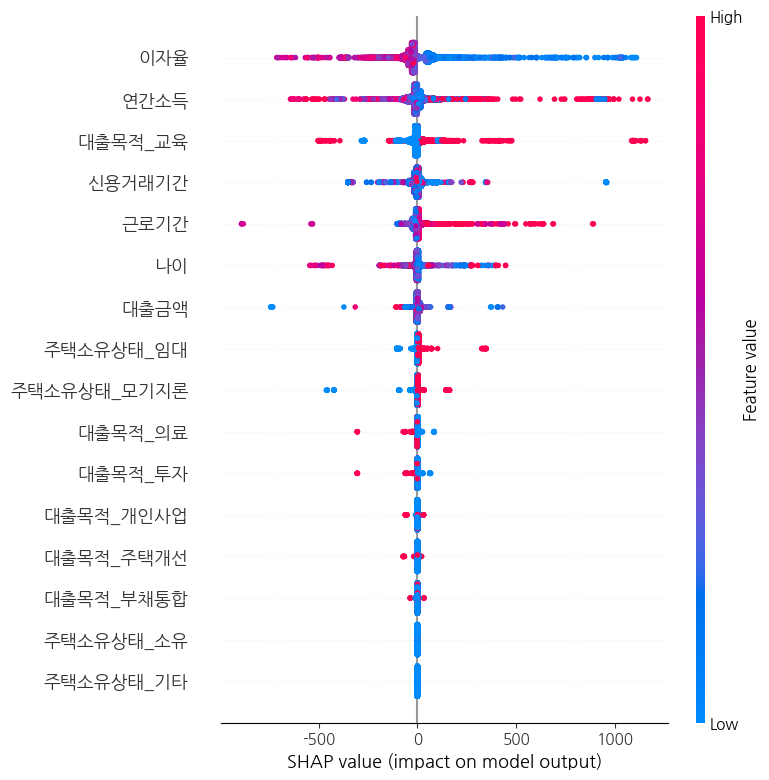


1 클래스 summary_plot


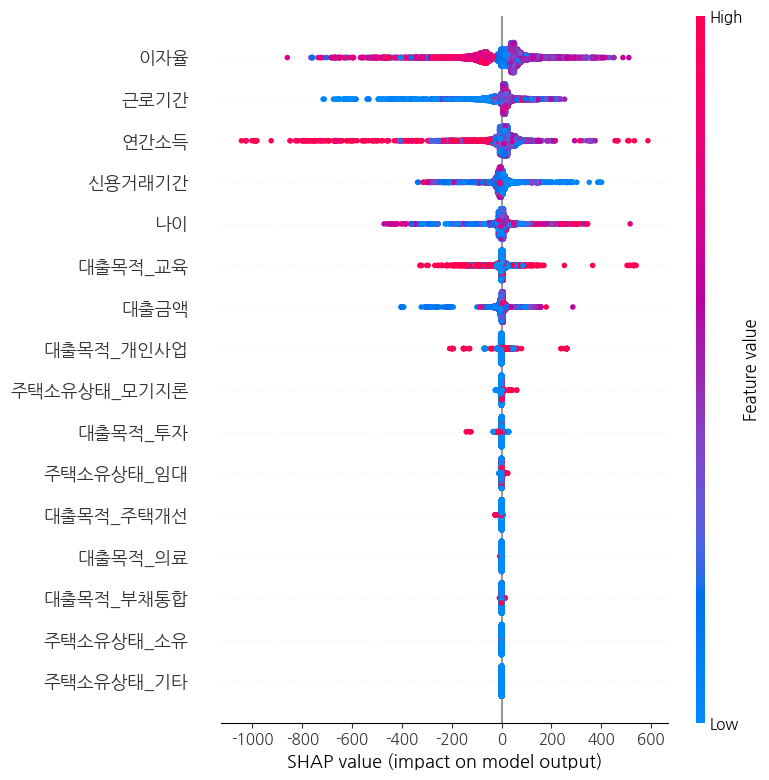


2 클래스 summary_plot


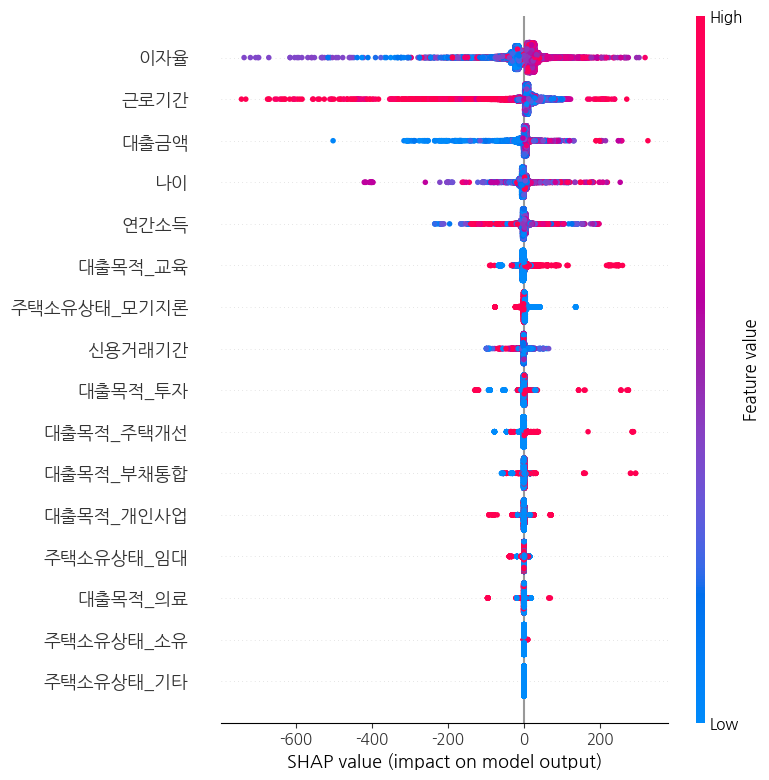


3 클래스 summary_plot


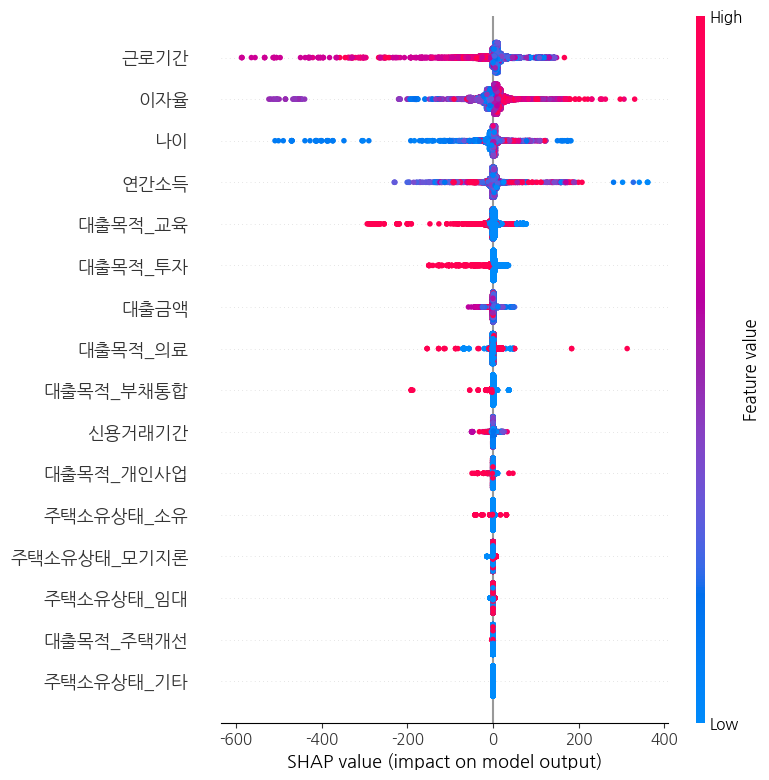


4 클래스 summary_plot


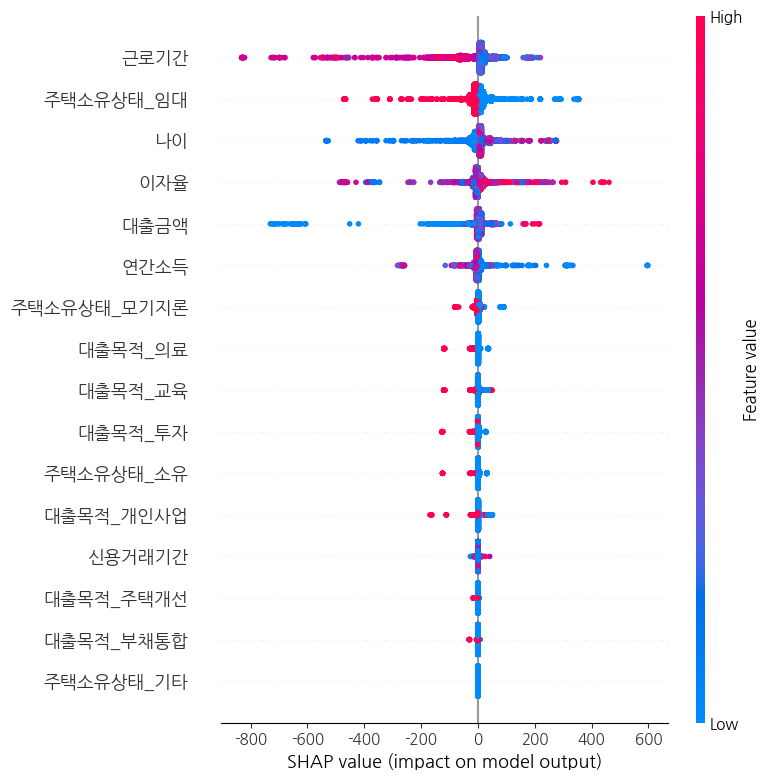


5 클래스 summary_plot


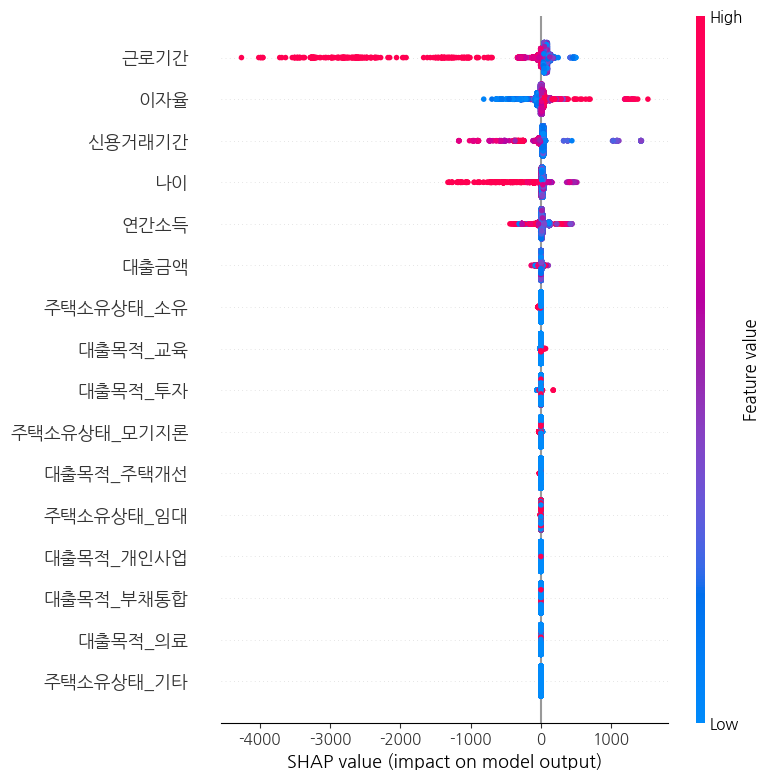


6 클래스 summary_plot


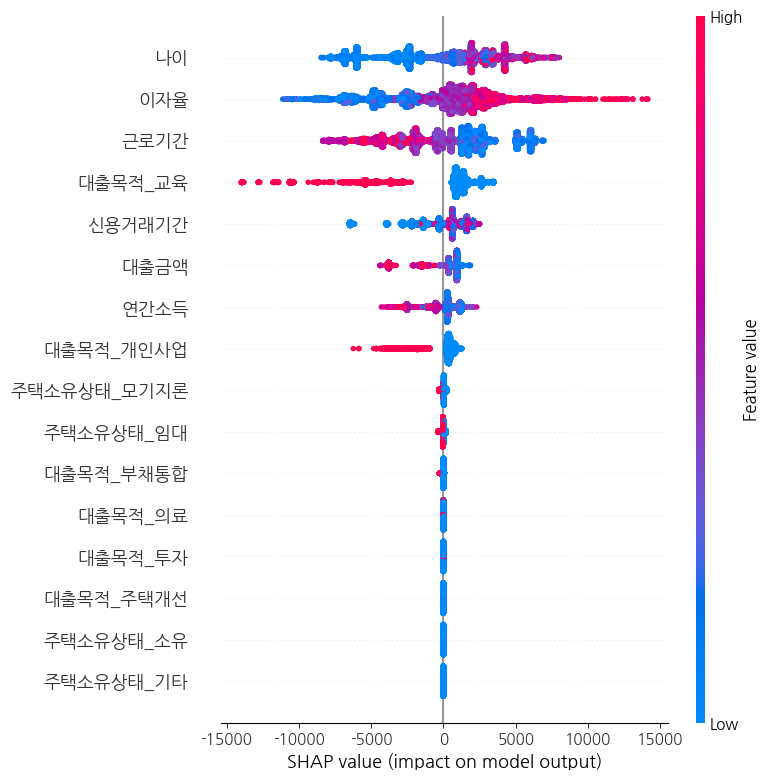

In [68]:
for c in range(7):
    print(f"{c} 클래스 summary_plot")
    shap.summary_plot(shap_values[:,:,c], test_ft)
    print()

In [69]:
for c in range(7):
    print(f"{c} 클래스 plot 시작")
    for col in test_ft.columns:
        shap.dependence_plot(col, shap_values[:,:,c], test_ft)

Output hidden; open in https://colab.research.google.com to view.